<a href="https://colab.research.google.com/github/Yiyuan80/MP/blob/main/bmi_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, MaxPool3D
from tensorflow.keras import Model
from tensorflow import keras
import time
import itertools
from itertools import combinations

In [3]:
# load filtered id
file = open('/content/drive/MyDrive/mesa/filtered_id.txt')
lines = file.read().split()
name_list = []
for i in lines:
  name_list.append(i) # convert txt file to a list

In [4]:
# load outcomes
indices = pd.read_csv('/content/drive/MyDrive/mesa/mesa_indices.csv',usecols=range(1,8))
e5 = pd.read_csv('/content/drive/MyDrive/mesa/mesae5_drepos_20151101.csv')
cvd = e5[['mesaid','ascvd5c','frci085c','frncep5c','dm035c','mtsy035c','cesd5c','htn5c','bmi5c','gender1','race1c','age5c']]
nsrr = pd.read_csv('/content/drive/MyDrive/mesa/mesa-sleep-dataset-0.4.0.csv')
dsdp = nsrr[['mesaid','epslpscl5c','hoostmeq5c']]
df = pd.merge(indices, cvd, how='left', on='mesaid')
df = pd.merge(df, dsdp, how='left', on='mesaid')

# data transformation
df['dm035c']=pd.cut(df['dm035c'],bins=[-1,0,3],labels=[0,1]).astype(float).astype('float32')
df['bmi5c']=pd.cut(df['bmi5c'],bins=[-1,30,60],labels=[0,1]).astype(float).astype('float32')
df['cesd5c']=pd.cut(df['cesd5c'],bins=[-1,15,60],labels=[0,1]).astype(float).astype('float32')
df['epslpscl5c']=pd.cut(df['epslpscl5c'],bins=[-1,10,60],labels=[0,1]).astype(float).astype('float32')
df['hoostmeq5c']=pd.cut(df['hoostmeq5c'],bins=[-1,18,60],labels=[0,1]).astype(float).astype('float32')
df['age5c']=pd.cut(df['age5c'],bins=[-1,69,200],labels=[0,1]).astype(float).astype('float32')

# create labels
diabetes = df['dm035c'].to_numpy()
metabolic_syndrome = df['mtsy035c'].to_numpy()
ces = df['cesd5c'].to_numpy()
ess = df['epslpscl5c'].to_numpy()
meq = df['hoostmeq5c'].to_numpy()
hypertension = df['htn5c'].to_numpy()
bmi = df['bmi5c'].to_numpy()
gender = df['gender1'].to_numpy()
age = df['age5c'].to_numpy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (202,212,213,216,222,224,226,236,238,279,342,346,350,371,373,375,379,380,382,387,388,393,395,399,400,403,1863,1875,1885,1888,1894,1900,1903,1924,1927,1930,1936,1939,1942,1951,1957,1966,1969,1975,1978,1981,1996,2075,2393) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
# load wake
wake = np.load('/content/drive/MyDrive/mesa/saved_data/wake.npy')
wake = wake.astype('float64')
print(wake.shape)

# exclude index where label is nan 
idx = np.argwhere(~np.isnan(bmi)).reshape(-1)
# split data into train and test set
rng = np.random.default_rng(2021)
idx_permutation = rng.permutation(idx)
train_idx = idx_permutation[260:]
test_idx = idx_permutation[:260]
print(train_idx.shape)
print(test_idx.shape)

(1278, 17, 2880)
(1016,)
(260,)


In [12]:
def random_chunk(arr):
  """randomly generate a (3,2880) chunk from a given array."""
  day_epochs = tf.reduce_sum(arr, axis=1)
  length_days = len(day_epochs[day_epochs!=2880])
  start_day = np.random.choice(range(1,length_days-2), 1)[0]
  return arr[start_day:(start_day+3), :]

def batch_generator(n, df, outcome, idx):
  """Randomly select n samples from the dataset."""
  batch_samples = []
  sample_idx = np.random.choice(idx,n,replace=False)
  labels = []

  for i in sample_idx:

    wake_sample = df[i,:,:]
    batch_samples.append(random_chunk(wake_sample))
    labels.append(outcome[i])

  batch_samples=np.stack(batch_samples)

  return batch_samples[:,:,:,tf.newaxis], np.array(labels)

In [13]:
X,y = batch_generator(64, wake, bmi, train_idx)
print(X.shape)
print(y.shape)

(64, 3, 2880, 1)
(64,)


In [24]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(filters=64, kernel_size=(1,10), strides=(1,5), padding='valid')
    self.conv2 = Conv2D(filters=128, kernel_size=(1,10), strides=(1,5), padding='valid')
    self.conv3 = Conv2D(filters=64, kernel_size=(3,6), strides=(1,3), padding='valid')

    self.maxpool1 = MaxPool2D(pool_size=(1, 5), padding='valid')
    self.maxpool2 = MaxPool2D(pool_size=(1, 2), padding='valid')
    # self.final = Dense(1, activation=None)
    self.d1 = Dense(32, activation='relu')

  def call(self, x):
    x = self.conv1(x)
    print(x.shape)
    x = self.maxpool1(x)
    print(x.shape)

    x = self.conv2(x)
    print(x.shape)
    x = self.maxpool2(x)
    print(x.shape)

    x = self.conv3(x)
    print(x.shape)
    
    x = self.d1(x)
    print(x.shape)

    x = tf.reduce_max(x, [2, 3])
    print(x.shape)

    x = tf.squeeze(x)
    print(x.shape)
    return x 

model = MyModel()
predictions = model(X)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss = loss_object(y, predictions)

# optimizer = tf.keras.optimizers.Adam()
lr = tf.keras.optimizers.schedules.CosineDecay(1e-3, 1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

(64, 3, 575, 64)
(64, 3, 115, 64)
(64, 3, 22, 128)
(64, 3, 11, 128)
(64, 1, 2, 64)
(64, 1, 2, 32)
(64, 1)
(64,)


In [25]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [26]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(labels, predictions)

In [27]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [28]:
NUM_BATCHES = 1000
epoch = []
acc = []
val_acc = []
loss = []
val_loss = []
metrics = {
    "epoch": epoch,
    "acc": acc,
    "test_acc":val_acc,
    "loss":loss,
    "test_loss": val_loss
}


for batch_idx in range(NUM_BATCHES):
  # reset losses and accuracies
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  # generate train and test batches
  train_batch, train_label =  batch_generator(64, wake, bmi, train_idx)
  # print(train_batch.shape, train_label.shape)
  test_batch, test_label =  batch_generator(64, wake, bmi, test_idx)

  # fit model and test
  train_step(train_batch, train_label)
  # train_temp(model.T)
  # print(model.T)
  test_step(test_batch, test_label)

  # record acc and loss
  metrics["epoch"].append(batch_idx)
  metrics["acc"].append(train_accuracy.result()*100)
  metrics["test_acc"].append(test_accuracy.result()*100)
  metrics["loss"].append(train_loss.result())
  metrics["test_loss"].append(test_loss.result())

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(batch_idx+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

(64, 3, 575, 64)
(64, 3, 115, 64)
(64, 3, 22, 128)
(64, 3, 11, 128)
(64, 1, 2, 64)
(64, 1, 2, 32)
(64, 1)
(64,)
(64, 3, 575, 64)
(64, 3, 115, 64)
(64, 3, 22, 128)
(64, 3, 11, 128)
(64, 1, 2, 64)
(64, 1, 2, 32)
(64, 1)
(64,)
(64, 3, 575, 64)
(64, 3, 115, 64)
(64, 3, 22, 128)
(64, 3, 11, 128)
(64, 1, 2, 64)
(64, 1, 2, 32)
(64, 1)
(64,)
Epoch 1, Loss: 0.7476935386657715, Accuracy: 57.8125, Test Loss: 0.862320065498352, Test Accuracy: 39.0625
Epoch 2, Loss: 0.8083959817886353, Accuracy: 43.75, Test Loss: 0.8447097539901733, Test Accuracy: 39.0625
Epoch 3, Loss: 0.8136723637580872, Accuracy: 43.75, Test Loss: 0.7818516492843628, Test Accuracy: 50.0
Epoch 4, Loss: 0.8260204792022705, Accuracy: 42.1875, Test Loss: 0.7869659662246704, Test Accuracy: 39.0625
Epoch 5, Loss: 0.7513432502746582, Accuracy: 45.3125, Test Loss: 0.8636205792427063, Test Accuracy: 34.375
Epoch 6, Loss: 0.8356366157531738, Accuracy: 37.5, Test Loss: 0.7958101630210876, Test Accuracy: 56.25
Epoch 7, Loss: 0.7899127006530

In [29]:
metrics = pd.DataFrame(metrics)
metrics['acc'] = metrics['acc'].astype(float)
metrics['test_acc'] = metrics['test_acc'].astype(float)
metrics['loss'] = metrics['loss'].astype(float)
metrics['test_loss'] = metrics['test_loss'].astype(float)
metrics_mean = metrics.groupby(np.arange(len(metrics))//10).mean()
metrics

,epoch,acc,test_acc,loss,test_loss
0,0,57.8125,39.0625,0.747694,0.862320
1,1,43.7500,39.0625,0.808396,0.844710
2,2,43.7500,50.0000,0.813672,0.781852
3,3,42.1875,39.0625,0.826020,0.786966
4,4,45.3125,34.3750,0.751343,0.863621
...,...,...,...,...,...
995,995,54.6875,60.9375,0.693147,0.693147
996,996,62.5000,59.3750,0.693147,0.693319
997,997,70.3125,60.9375,0.693147,0.693147
998,998,56.2500,62.5000,0.693147,0.693147


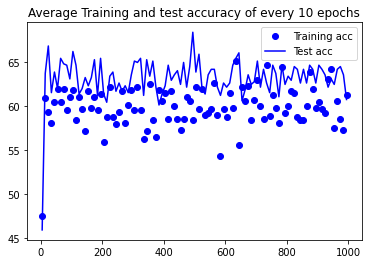

In [30]:
plt.plot(metrics_mean['epoch'], metrics_mean['acc'], 'bo', label='Training acc')
plt.plot(metrics_mean['epoch'], metrics_mean['test_acc'], 'b', label='Test acc')
plt.title('Average Training and test accuracy of every 10 epochs')
plt.legend()

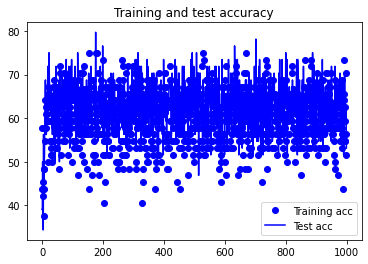

In [31]:
plt.plot(metrics['epoch'], metrics['acc'], 'bo', label='Training acc')
plt.plot(metrics['epoch'], metrics['test_acc'], 'b', label='Test acc')
plt.title('Training and test accuracy')
plt.legend()

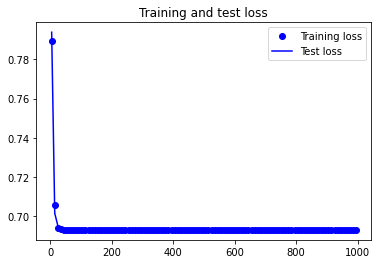

In [32]:
plt.plot(metrics_mean['epoch'], metrics_mean['loss'], 'bo', label='Training loss')
plt.plot(metrics_mean['epoch'], metrics_mean['test_loss'], 'b', label='Test loss')
plt.title('Training and test loss')
plt.legend()

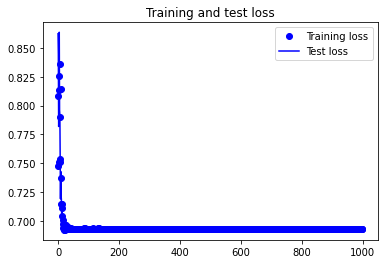

In [33]:
plt.plot(metrics['epoch'], metrics['loss'], 'bo', label='Training loss')
plt.plot(metrics['epoch'], metrics['test_loss'], 'b', label='Test loss')
plt.title('Training and test loss')
plt.legend()